# 準備

In [ ]:
# バージョン指定時にコメントアウト
#!pip install torch==1.7.0
#!pip install torchvision==0.8.1

import torch
import torchvision
# バージョンの確認
print(torch.__version__) 
print(torchvision.__version__) 

1.7.0+cu101
0.8.1+cu101


In [ ]:
# Google ドライブにマウント
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Colab Notebooks/gan_sample/chapter2'

/content/gdrive/MyDrive/Colab Notebooks/gan_sample/chapter2


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optimizers
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# データセットの作成

In [ ]:
np.random.seed(1234)
torch.manual_seed(1234)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# データの取得
root = os.path.join('data', 'mnist')
transform = transforms.Compose([transforms.ToTensor(),
                                lambda x: x.view(-1)])
mnist_train = \
    torchvision.datasets.MNIST(root=root,
                                      download=True,
                                      train=True,
                                      transform=transform)
mnist_test = \
    torchvision.datasets.MNIST(root=root,
                                      download=True,
                                      train=False,
                                      transform=transform)
train_dataloader = DataLoader(mnist_train,
                              batch_size=100,
                              shuffle=True)
test_dataloader = DataLoader(mnist_test,
                              batch_size=1,
                              shuffle=False)

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw


Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw


Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


# ネットワークの定義

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(784, 200)
        self.l2 = nn.Linear(200, 784)

    def forward(self, x):
        # エンコーダ
        h = self.l1(x)
        # 活性化関数
        h = torch.relu(h)

        # デコーダ
        h = self.l2(h)
        # シグモイド関数で0～1の値域に変換   
        y = torch.sigmoid(h)

        return y

# 学習の実行

In [ ]:
# モデルの設定
model = Autoencoder(device=device).to(device)
# 損失関数の設定
criterion = nn.BCELoss()
# 最適化関数の設定
optimizer = optimizers.Adam(model.parameters())

In [ ]:
epochs = 10
# エポックのループ
for epoch in range(epochs):
    train_loss = 0.
    # バッチサイズのループ
    for (x, _) in train_dataloader:
        x = x.to(device)
        # 訓練モードへの切替
        model.train()
        # 順伝播計算
        preds = model(x)
        # 入力画像xと復元画像predsの誤差計算
        loss = criterion(preds, x)
        # 勾配の初期化
        optimizer.zero_grad()
        # 誤差の勾配計算
        loss.backward()
        # パラメータの更新
        optimizer.step()
        # 訓練誤差の更新
        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    print('Epoch: {}, Loss: {:.3f}'.format(
        epoch+1,
        train_loss
    ))

Epoch: 1, Loss: 0.153
Epoch: 2, Loss: 0.085
Epoch: 3, Loss: 0.075
Epoch: 4, Loss: 0.071
Epoch: 5, Loss: 0.069
Epoch: 6, Loss: 0.068
Epoch: 7, Loss: 0.067
Epoch: 8, Loss: 0.067
Epoch: 9, Loss: 0.066
Epoch: 10, Loss: 0.066


# 画像の復元

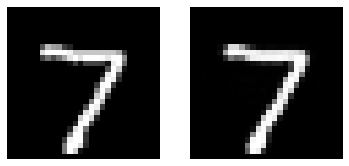

In [ ]:
# dataloaderからのデータ取り出し
x, _ = next(iter(test_dataloader))
x = x.to(device)

# 評価モードへの切替
model.eval()
# 復元画像
x_rec = model(x)

# 入力画像、復元画像の表示
for i, image in enumerate([x, x_rec]):
    image = image.view(28, 28).detach().cpu().numpy()
    plt.subplot(1, 2, i+1)
    plt.imshow(image, cmap='binary_r')
    plt.axis('off')
plt.show()